In [9]:
# Local Module
from modules import process as prc

# Data Science
import pandas
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Display
from IPython.display import display

In [10]:
train_data = pandas.read_csv('../data/training_data.csv', sep=',', header=0)
test_data = pandas.read_csv('../data/testing_data.csv', sep=',', header=0)

X_train = train_data.iloc[:, 0:6]
X_test = test_data.iloc[:, 0:6]

y_train = train_data.iloc[:, -1]
y_test = test_data.iloc[:, -1]

In [11]:
# bernoulli
BernNP = BernoulliNB(binarize = True)
BernNP.fit(X_train, y_train)

y_pred = BernNP.predict(X_test)
print(prc.accuracy_score(y_pred, y_test))

96.0


In [12]:
# Gaussian
gaussNB = GaussianNB()
gaussNB.fit(X_train, y_train)

y_pred = gaussNB.predict(X_test)

print(prc.accuracy_score(y_pred, y_test))

96.0


In [13]:
# ID3
dTree = DecisionTreeClassifier(criterion='entropy')
dTree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

[Text(177.72249087591243, 211.04470588235293, 'net_worth <= -6.242\nentropy = 0.996\nsamples = 9130\nvalue = [4237, 4893]'),
 Text(74.7776003649635, 198.25411764705882, 'net_barracks <= -1.5\nentropy = 0.317\nsamples = 4300\nvalue = [4053, 247]'),
 Text(25.55802919708029, 185.4635294117647, 'net_worth <= -9836.942\nentropy = 0.075\nsamples = 3743\nvalue = [3709, 34]'),
 Text(8.96058394160584, 172.6729411764706, 'net_xp <= -5776.533\nentropy = 0.027\nsamples = 3332\nvalue = [3323, 9]'),
 Text(3.2583941605839417, 159.88235294117646, 'score <= -7.5\nentropy = 0.004\nsamples = 3067\nvalue = [3066, 1]'),
 Text(1.6291970802919709, 147.09176470588235, 'entropy = 0.0\nsamples = 2698\nvalue = [2698, 0]'),
 Text(4.887591240875913, 147.09176470588235, 'net_xp <= -30189.208\nentropy = 0.027\nsamples = 369\nvalue = [368, 1]'),
 Text(3.2583941605839417, 134.30117647058825, 'net_xp <= -30546.142\nentropy = 0.131\nsamples = 55\nvalue = [54, 1]'),
 Text(1.6291970802919709, 121.51058823529411, 'entropy 

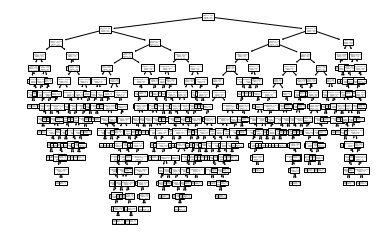

In [14]:
display(plot_tree(dTree, feature_names=X_train.keys().values))